[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/13_models_with_memory.ipynb)

# Chapter 13 - Models with Memory


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz    

In [2]:
%load_ext watermark

In [3]:
from functools import partial

# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 1.0.1


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
USE_XLA = False

In [7]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat

def sample_posterior(jdc, 
                      observed_data, 
                      params, 
                      num_chains=NUMBER_OF_CHAINS,
                      init_state=None, 
                      bijectors=None,                              
                      num_samples=NUMBER_OF_SAMPLES, 
                      burnin=NUMBER_OF_BURNIN):       
    
    if init_state is None:
        init_state = list(jdc.sample(NUMBER_OF_CHAINS)[:-1])
        
    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]


    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    
    step_size = 0.1
    results, sample_stats = run_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))    
    posterior = dict(zip(params, results))
    return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

## Dataset URL


In [8]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

REEDFROGS_DATASET_PATH = f"{_BASE_URL}/reedfrogs.csv"
CHIMPANZEES_DATASET_PATH = f"{_BASE_URL}/chimpanzees.csv"

## Code 13.1


Reedfrogs dataset is about the tadpole mortality. The objective will be determine the `surv` out of an initial count, `density`.

Author explains that within each tank there are things that go unmeasured and these unmeasured factors create variation in survival across tanks.

These tanks are an example of **cluster** variable

He argues that both of the approaches - 
    * treat the tanks independetly i.e. each of them have their unique intecepts 
    * treat them togather 

have issues. 

for e.g.

    - unique intecepts will imply that we are not using information from other tanks.
    - all togather will have the problem ignoring varations in baseline survival 
    
A multilevel model, in which we simultaneously estimate both an intercept for each tank and the variation among tanks, is what we want !

This type of a model is called **Varying intercepts** model.
        


In [9]:
d = pd.read_csv(REEDFROGS_DATASET_PATH, sep=";")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


## Code 13.2

Our simple model. This will give us 48 different intercepts. This means that it does not use the information available between each tank

In [10]:
d["tank"] = np.arange(d.shape[0])
alpha_sample_shape = d["tank"].shape[0]

dat = dict(
    S=tf.cast(d.surv.values, dtype=tf.float32),
    N=tf.cast(d.density.values, dtype=tf.float32),
    tank=d.tank.values)


def model_13_1(tid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=alpha_sample_shape))
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, tid, axis=-1)))        
        
      S = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_1 = model_13_1(dat["tank"], dat["N"])

In [11]:
NUM_CHAINS_FOR_13_1 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_1, alpha_sample_shape])
]

bijectors = [
    tfb.Identity()
]

trace_13_1 = sample_posterior(jdc_13_1,
                               observed_data=(dat["S"],),
                               params=['alpha'],
                               num_chains=NUM_CHAINS_FOR_13_1,
                               init_state=init_state,
                               bijectors=bijectors)

az.summary(trace_13_1, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.73,0.83,0.25,3.25,0.03,0.02,842.88,705.32,873.06,366.80,1.00
alpha[1],2.44,0.94,0.63,4.13,0.04,0.03,563.67,516.04,596.07,386.13,1.00
alpha[2],0.79,0.70,-0.43,2.13,0.02,0.02,1132.16,565.83,1150.33,387.19,1.00
alpha[3],2.39,0.86,0.99,4.07,0.04,0.03,518.02,473.55,526.09,479.85,1.00
alpha[4],1.72,0.77,0.22,3.05,0.03,0.02,620.74,532.28,638.98,430.74,1.00
alpha[5],1.72,0.77,0.24,3.06,0.03,0.02,803.70,686.57,823.98,488.28,1.00
alpha[6],2.37,0.87,0.77,3.85,0.04,0.03,498.04,424.80,529.86,593.93,1.00
alpha[7],1.69,0.78,0.46,3.31,0.03,0.02,673.61,600.10,681.17,471.48,1.01
alpha[8],-0.37,0.55,-1.40,0.66,0.01,0.02,1709.20,400.14,1695.10,452.51,1.00
alpha[9],1.75,0.83,0.25,3.45,0.03,0.03,605.90,424.25,697.50,446.97,1.00


In [12]:
trace_13_1.sample_stats

<xarray.Dataset>
Dimensions:           (chain: 2, draw: 500)
Coordinates:
  * chain             (chain) int64 0 1
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
Data variables:
    mean_tree_accept  (chain, draw) float32 -0.7715149 0.56355286 ... -2.402954
Attributes:
    created_at:  2020-02-18T21:51:57.474468

## Code 13.3

We now build a multilevel model, which adaptively pools information across tanks.

In order to do so, we must make the prior for the parameter **alpha** a function of some new parameters.

Prior itself has priors !


In [13]:
def model_13_2(tid, N):
    def _generator():     
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma), sample_shape=alpha_sample_shape)
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, tid, axis=-1)))              
        
      S = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_2 = model_13_2(dat["tank"], dat["N"])

In [14]:
NUM_CHAINS_FOR_13_2 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_2]),
    tf.ones([NUM_CHAINS_FOR_13_2]),
    tf.zeros([NUM_CHAINS_FOR_13_2, alpha_sample_shape])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

In [15]:
trace_13_2 = sample_posterior(jdc_13_2,
                           observed_data=(dat["S"],),
                           params=['a_bar', 'sigma', 'alpha'],
                           num_chains=NUM_CHAINS_FOR_13_2, 
                           init_state=init_state,
                           bijectors=bijectors)

az.summary(trace_13_2, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.34,0.23,0.88,1.79,0.02,0.01,172.99,152.33,157.90,184.47,1.02
sigma,1.64,0.25,1.26,2.09,0.04,0.03,43.17,43.15,45.80,127.04,1.05
alpha[0],2.14,0.90,0.68,3.96,0.13,0.10,44.11,39.08,49.94,68.01,1.06
alpha[1],3.63,1.59,1.37,7.01,0.60,0.44,7.04,7.04,6.66,18.50,1.24
alpha[2],1.02,0.71,-0.16,2.58,0.08,0.06,74.98,74.98,75.54,89.08,1.05
alpha[3],3.13,1.25,1.39,5.89,0.28,0.22,19.23,16.87,32.68,43.70,1.06
alpha[4],2.18,0.85,0.84,3.87,0.10,0.07,70.53,68.12,73.09,157.62,1.01
alpha[5],1.98,0.75,0.66,3.35,0.09,0.06,71.73,70.72,73.45,95.44,1.02
alpha[6],3.12,1.04,1.48,4.93,0.14,0.10,57.88,55.27,62.84,132.83,1.04
alpha[7],2.09,0.86,0.46,3.58,0.12,0.09,51.73,46.31,57.19,180.30,1.02


## Code 13.4

In [16]:
# we must compute the likelhood before using arviz to do comparison
def compute_and_store_log_likelihood_for_model_13_1(num_chains):

    def log_like_13_1(a):
        p = tf.sigmoid(tf.squeeze(tf.gather(a, dat["tank"], axis=-1)))        
        return tfd.Binomial(total_count=dat["N"], probs=p).log_prob(dat["S"])

    log_likelihood_13_1 = []

    for i in range(num_chains):
        alpha = trace_13_1.posterior["alpha"].values[i]
        log_likelihood = np.array(list(map(log_like_13_1, alpha)))
        log_likelihood_13_1.append(log_likelihood)

    log_likelihood_13_1 = np.array(log_likelihood_13_1)

    # we need to insert this in the sampler_stats
    sample_stats_13_1 = trace_13_1.sample_stats

    coords = [sample_stats_13_1.coords['chain'], sample_stats_13_1.coords['draw'], np.arange(48)]

    sample_stats_13_1["log_likelihood"] = xr.DataArray(
        log_likelihood_13_1, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_1(num_chains=2)

In [17]:
def compute_and_store_log_likelihood_for_model_13_2(num_chains):

    def log_like_13_2(a):
        p = tf.sigmoid(tf.squeeze(tf.gather(a, dat["tank"], axis=-1)))        
        return tfd.Binomial(total_count=dat["N"], probs=p).log_prob(dat["S"])

    log_likelihood_13_2 = []

    for i in range(num_chains):
        alpha = trace_13_2.posterior["alpha"].values[i]
        log_likelihood = np.array(list(map(log_like_13_2, alpha)))
        log_likelihood_13_2.append(log_likelihood)

    log_likelihood_13_2 = np.array(log_likelihood_13_2)

    # we need to insert this in the sampler_stats
    sample_stats_13_2 = trace_13_2.sample_stats

    coords = [sample_stats_13_2.coords['chain'], sample_stats_13_2.coords['draw'], np.arange(48)]

    sample_stats_13_2["log_likelihood"] = xr.DataArray(
        log_likelihood_13_2, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_2(num_chains=2)

In [18]:
az.compare({"m13.1": trace_13_1, "m13.2": trace_13_2})

/Users/ksachdeva/Desktop/Dev/myoss/rethinking-tensorflow-probability/env/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.2,0,196.917,19.364,0,0.999684,5.49699,0,True,deviance
m13.1,1,217.401,26.5464,20.4845,0.000316454,7.48816,4.43932,True,deviance


## Code 13.5

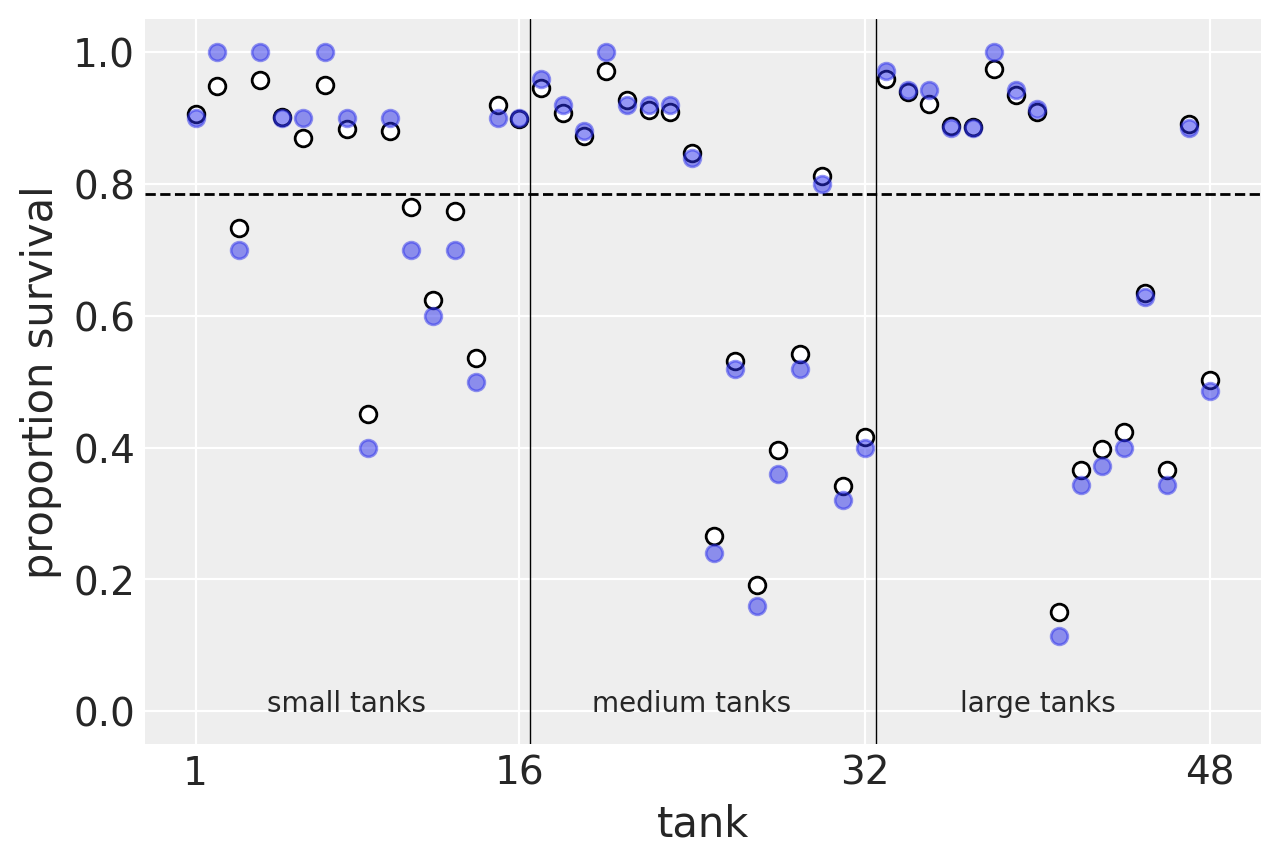

In [19]:
# compute median intercept for each tank
# also transform to probability with logistic

sample_alpha = trace_13_2.posterior["alpha"].values[0]
d["propsurv.est"] = tf.sigmoid(np.mean(sample_alpha, 0)).numpy()

# display raw proportions surviving in each tank
plt.plot(np.arange(1, 49), d.propsurv, "o", alpha=0.5, zorder=3)
plt.gca().set(ylim=(-0.05, 1.05), xlabel="tank", ylabel="proportion survival")
plt.gca().set(xticks=[1, 16, 32, 48], xticklabels=[1, 16, 32, 48])

# overlay posterior means
plt.plot(np.arange(1, 49), d["propsurv.est"], "ko", mfc="w")

sample_a_bar = trace_13_2.posterior["a_bar"].values[0]


# mark posterior mean probability across tanks
plt.gca().axhline(y=tf.reduce_mean(tf.sigmoid(sample_a_bar)).numpy(), c="k", ls="--", lw=1)

# draw vertical dividers between tank densities
plt.gca().axvline(x=16.5, c="k", lw=0.5)
plt.gca().axvline(x=32.5, c="k", lw=0.5)
plt.annotate("small tanks", (8, 0), ha="center")
plt.annotate("medium tanks", (16 + 8, 0), ha="center")
plt.annotate("large tanks", (32 + 8, 0), ha="center");


Here is how to read above plot -

* The dashed line locates the average proportion of survivors across all tanks
* The vertical lines divide tanks with different initial densities of tadpoles: small tanks (10 tad- poles), medium tanks (25), and large tanks (35).
* Empirical proportions of survivors in each tadpole tank, shown by the filled blue points, plotted with the 48 per-tank parameters from the multilevel model, shown by the black circles

In every tank, the posterior mean from the multilevel model is closer to the dashed line than the empir- ical proportion is.

## Code 13.6

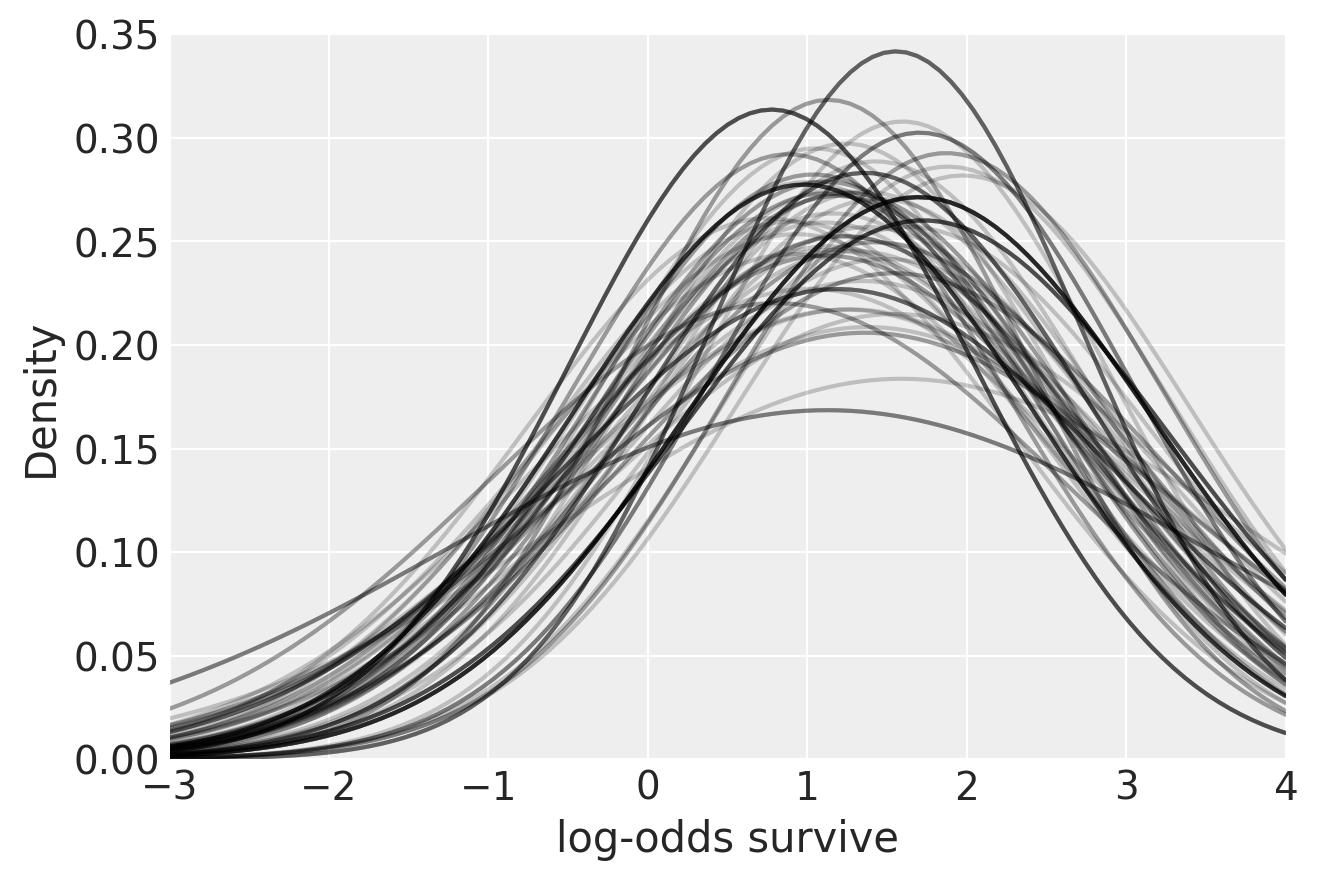

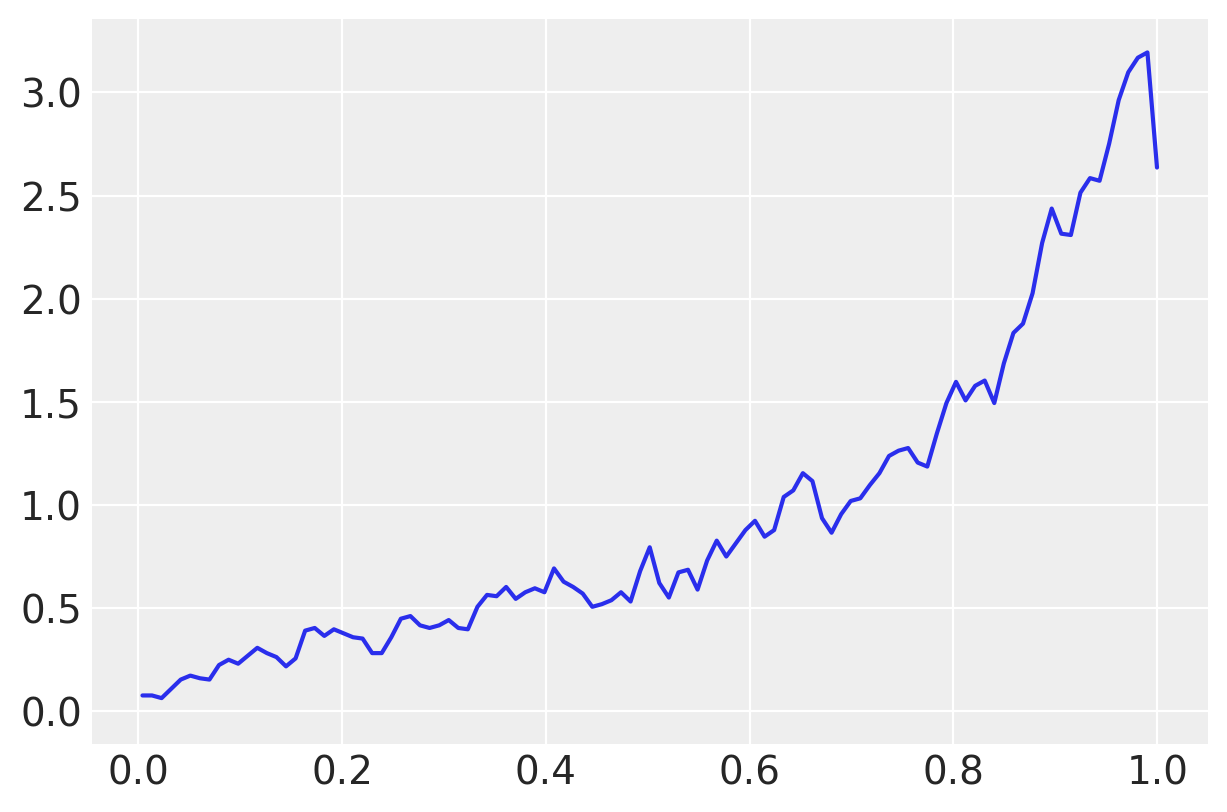

In [20]:
sample_sigma = trace_13_2.posterior["sigma"].values[0]


# show first 100 populations in the posterior
plt.subplot(xlim=(-3, 4), ylim=(0, 0.35),
            xlabel="log-odds survive", ylabel="Density")
for i in range(100):
    x = np.linspace(-3, 4, 101)
    plt.plot(x, tf.exp(tfd.Normal(sample_a_bar[i], sample_sigma[i])
                       .log_prob(x)), "k", alpha=0.2)
plt.show()

# sample 8000 imaginary tanks from the posterior distribution
idxs = np.random.randint(size=(8000,), low=0, high=499)

sim_tanks = tfd.Normal(sample_a_bar[idxs], sample_sigma[idxs]).sample()

# transform to probability and visualize
az.plot_kde(tf.sigmoid(sim_tanks), bw=0.3);

## Code 13.7

In [21]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)

## Code 13.8

In [22]:
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,))

## Code 13.9

In [23]:
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))

dsim.describe()

,pond,Ni,true_a
count,60.000000,60.000000,60.000000
mean,30.500000,18.750000,1.663892
std,17.464249,12.024868,1.448978
min,1.000000,5.000000,-1.968106
25%,15.750000,8.750000,0.574265
50%,30.500000,17.500000,1.626484
75%,45.250000,27.500000,2.719836
max,60.000000,35.000000,5.017320


## Code 13.10

In [24]:
print(type(range(3)))
print(type(np.arange(3)))

<class 'range'>
<class 'numpy.ndarray'>


## Code 13.11

In [25]:
dsim["Si"] = tfd.Binomial(tf.cast(dsim.Ni.values, dtype=tf.float32), logits=dsim.true_a.values).sample()

## Code 13.12

In [26]:
dsim["p_nopool"] = dsim.Si / dsim.Ni

## Code 13.13

In [27]:
alpha_sample_shape = dsim.pond.shape[0]

In [28]:
dat = dict(
    Si=tf.cast(dsim.Si.values, tf.float32),
    true_a=tf.cast(dsim.true_a.values, tf.float32),
    Ni=tf.cast(dsim.Ni.values, dtype=tf.float32),
    pond=dsim.pond.values - 1
)

In [29]:
def model_13_3(pid, N):
    def _generator():     
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma), sample_shape=alpha_sample_shape)
      p = tf.sigmoid(tf.squeeze(tf.gather(alpha, pid, axis=-1)))              
        
      Si = yield tfd.Independent(tfd.Binomial(total_count=N, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_3 = model_13_3(dat["pond"], dat["Ni"])

In [30]:
NUM_CHAINS_FOR_13_3 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_3]),
    tf.ones([NUM_CHAINS_FOR_13_3]),
    tf.zeros([NUM_CHAINS_FOR_13_3, alpha_sample_shape])
]

In [31]:
bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Identity()
]

In [32]:
trace_13_3 = sample_posterior(jdc_13_3,
                               observed_data=(dat["Si"],),
                               params=['a_bar', 'sigma', 'alpha'],
                               num_chains=NUM_CHAINS_FOR_13_3, 
                               init_state=init_state,
                               bijectors=bijectors)

## Code 13.14

In [33]:
az.summary(trace_13_3, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,1.60,0.18,1.28,1.93,0.01,0.01,215.58,201.16,223.23,187.28,1.00
sigma,1.32,0.16,1.02,1.62,0.02,0.01,65.43,65.43,64.30,282.22,1.03
alpha[0],2.28,0.98,0.53,4.06,0.12,0.09,64.44,58.53,74.27,92.32,1.05
alpha[1],2.47,0.79,1.11,4.02,0.11,0.08,55.36,55.36,55.71,99.66,1.04
alpha[2],0.84,0.77,-0.45,2.44,0.08,0.06,97.50,97.00,98.83,119.25,1.00
...,...,...,...,...,...,...,...,...,...,...,...
alpha[55],1.43,0.40,0.68,2.16,0.02,0.02,294.51,289.52,296.74,313.37,1.01
alpha[56],1.13,0.38,0.35,1.79,0.02,0.01,457.89,417.99,471.28,436.28,1.01
alpha[57],3.12,0.82,1.63,4.68,0.10,0.07,74.83,63.50,88.28,135.71,1.02
alpha[58],-0.20,0.33,-0.75,0.44,0.01,0.01,481.71,423.78,481.57,471.66,1.00


## Code 13.15

In [34]:
sample_alpha = trace_13_3.posterior["alpha"].values[0]
dsim["p_partpool"] = tf.reduce_mean(tf.sigmoid(sample_alpha)).numpy()

## Code 13.16

In [35]:
dsim["p_true"] = tf.sigmoid(dsim.true_a.values).numpy()

## Code 13.17

In [36]:
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()

## Code 13.18

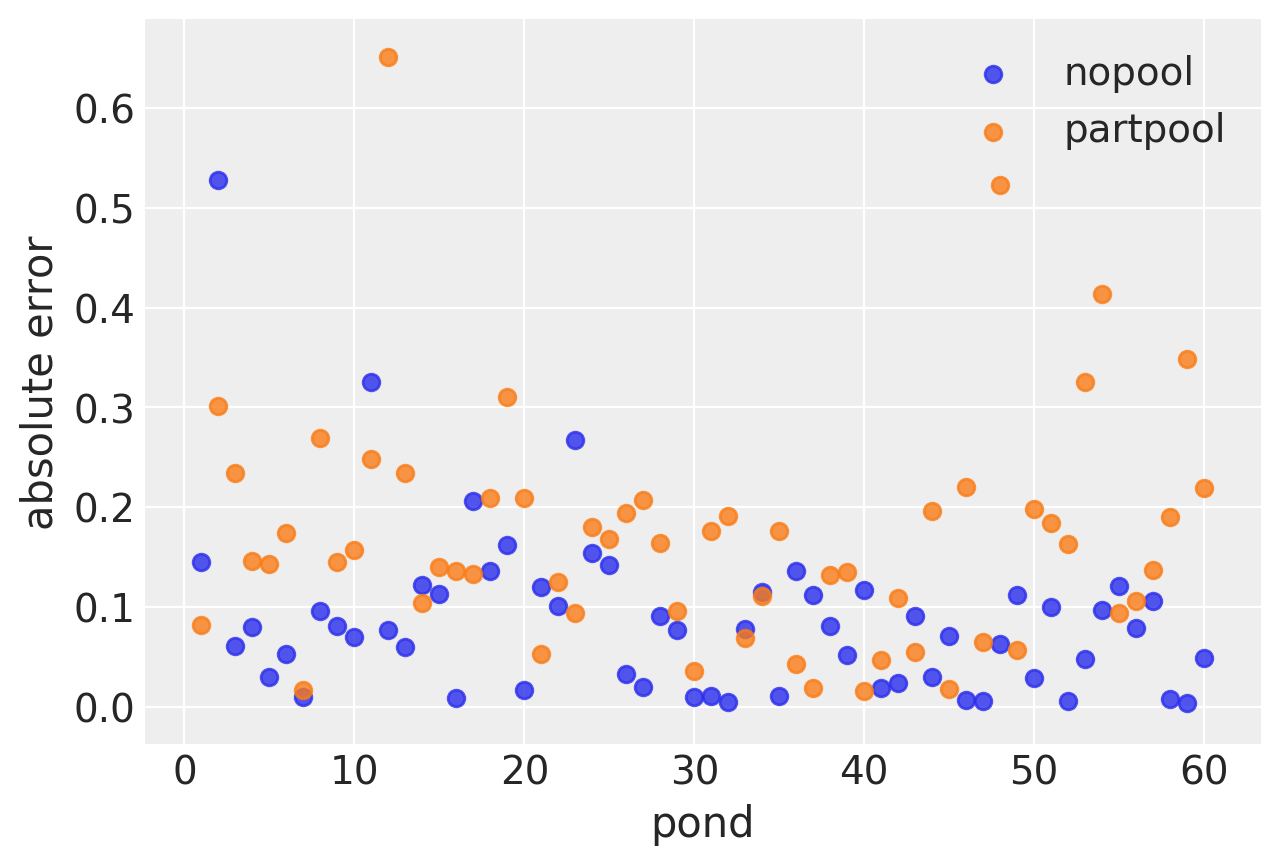

In [37]:
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

## Code 13.19

In [38]:
dsim["nopool_error"] = nopool_error
dsim["partpool_error"] = partpool_error
nopool_avg = dsim.groupby("Ni")["nopool_error"].mean()
partpool_avg = dsim.groupby("Ni")["partpool_error"].mean()

## Code 13.20

In [39]:
a_bar = 1.5
sigma = 1.5
nponds = 60
Ni = np.repeat(np.array([5, 10, 25, 35]), repeats=15)
a_pond = tfd.Normal(a_bar, sigma).sample((nponds,)).numpy()
dsim = pd.DataFrame(dict(pond=range(1, nponds + 1), Ni=Ni, true_a=a_pond))
dsim["Si"] = tfd.Binomial(tf.cast(dsim.Ni.values, dtype=tf.float32), logits=dsim.true_a.values).sample()
dsim["p_nopool"] = dsim.Si / dsim.Ni

newdat = dict(Si=tf.cast(dsim.Si.values, dtype=tf.float32),
              Ni=tf.cast(dsim.Ni.values, dtype=tf.float32),
              pond=dsim.pond.values - 1
)

jdc_13_3new = model_13_3(newdat["pond"], newdat["Ni"])

In [40]:
trace_13_3new = sample_posterior(jdc_13_3new,
                               observed_data=(newdat["Si"],),
                               params=['a_bar', 'sigma', 'alpha'],
                               num_chains=NUM_CHAINS_FOR_13_3, 
                               init_state=init_state,
                               bijectors=bijectors)

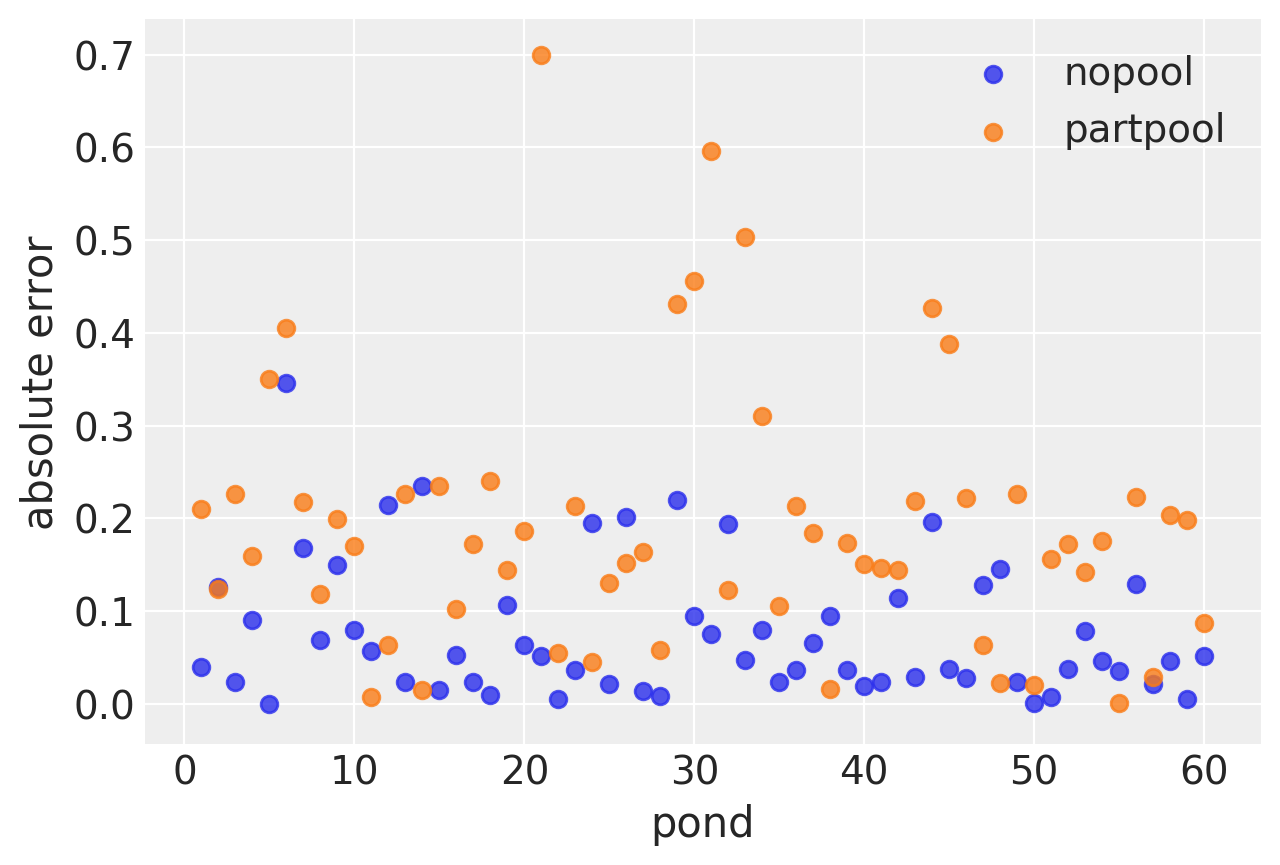

In [41]:
sample_alpha = trace_13_3new.posterior["alpha"].values[0]
dsim["p_partpool"] = tf.reduce_mean(tf.sigmoid(sample_alpha)).numpy()
dsim["p_true"] = tf.sigmoid(dsim.true_a.values).numpy()
nopool_error = (dsim.p_nopool - dsim.p_true).abs()
partpool_error = (dsim.p_partpool - dsim.p_true).abs()
plt.scatter(range(1, 61), nopool_error, label="nopool", alpha=0.8)
plt.gca().set(xlabel="pond", ylabel="absolute error")
plt.scatter(range(1, 61), partpool_error, label="partpool", alpha=0.8)
plt.legend();

## Code 13.21

In [42]:
d = pd.read_csv(CHIMPANZEES_DATASET_PATH, sep=";")
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat = dict(
    pulled_left=tf.cast(d.pulled_left.values, dtype=tf.float32), 
    actor=d.actor.values - 1,
    block_id=d.block.values - 1, 
    treatment=d.treatment.values - 1
)


def model_13_4(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      gamma = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_g), sample_shape=6)  
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(gamma, block_id, axis=-1))
      term3 = tf.squeeze(tf.gather(beta, treatment, axis=-1))
        
      p = tf.sigmoid(term1 + term2 + term3)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_4 = model_13_4(dat["actor"], dat["block_id"], dat["treatment"])

In [43]:
NUM_CHAINS_FOR_13_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

trace_13_4 = sample_posterior(jdc_13_4,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'alpha', 'gamma', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_4, 
                               init_state=init_state,
                               bijectors=bijectors)

## Code 13.22

In [44]:
az.summary(trace_13_4, round_to=2, kind='all')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,0.49,0.72,-0.82,1.76,0.13,0.09,32.25,32.25,33.42,54.59,1.04
sigma_a,1.97,0.59,1.13,3.14,0.14,0.10,18.75,18.75,19.08,190.45,1.09
sigma_g,0.21,0.16,0.05,0.47,0.03,0.02,31.03,31.03,23.22,16.63,1.07
alpha[0],-0.38,0.37,-1.03,0.31,0.06,0.04,37.25,37.25,37.17,149.38,1.08
alpha[1],4.58,1.16,2.70,6.80,0.32,0.23,13.03,13.03,16.65,27.53,1.11
alpha[2],-0.70,0.37,-1.40,-0.02,0.06,0.04,44.37,44.37,44.48,114.92,1.07
alpha[3],-0.70,0.32,-1.20,-0.01,0.05,0.04,37.06,37.06,38.36,176.53,1.06
alpha[4],-0.39,0.36,-1.06,0.25,0.08,0.05,23.03,23.03,22.09,105.95,1.09
alpha[5],0.57,0.34,-0.05,1.19,0.06,0.04,34.63,34.63,32.99,98.26,1.08
alpha[6],2.15,0.47,1.17,2.87,0.07,0.05,48.20,48.20,49.91,78.98,1.03


Note that there is variation across parameters when it comes to effective sample size (ess_mean). This is because some parameters spends a lot of time near a boundary. 

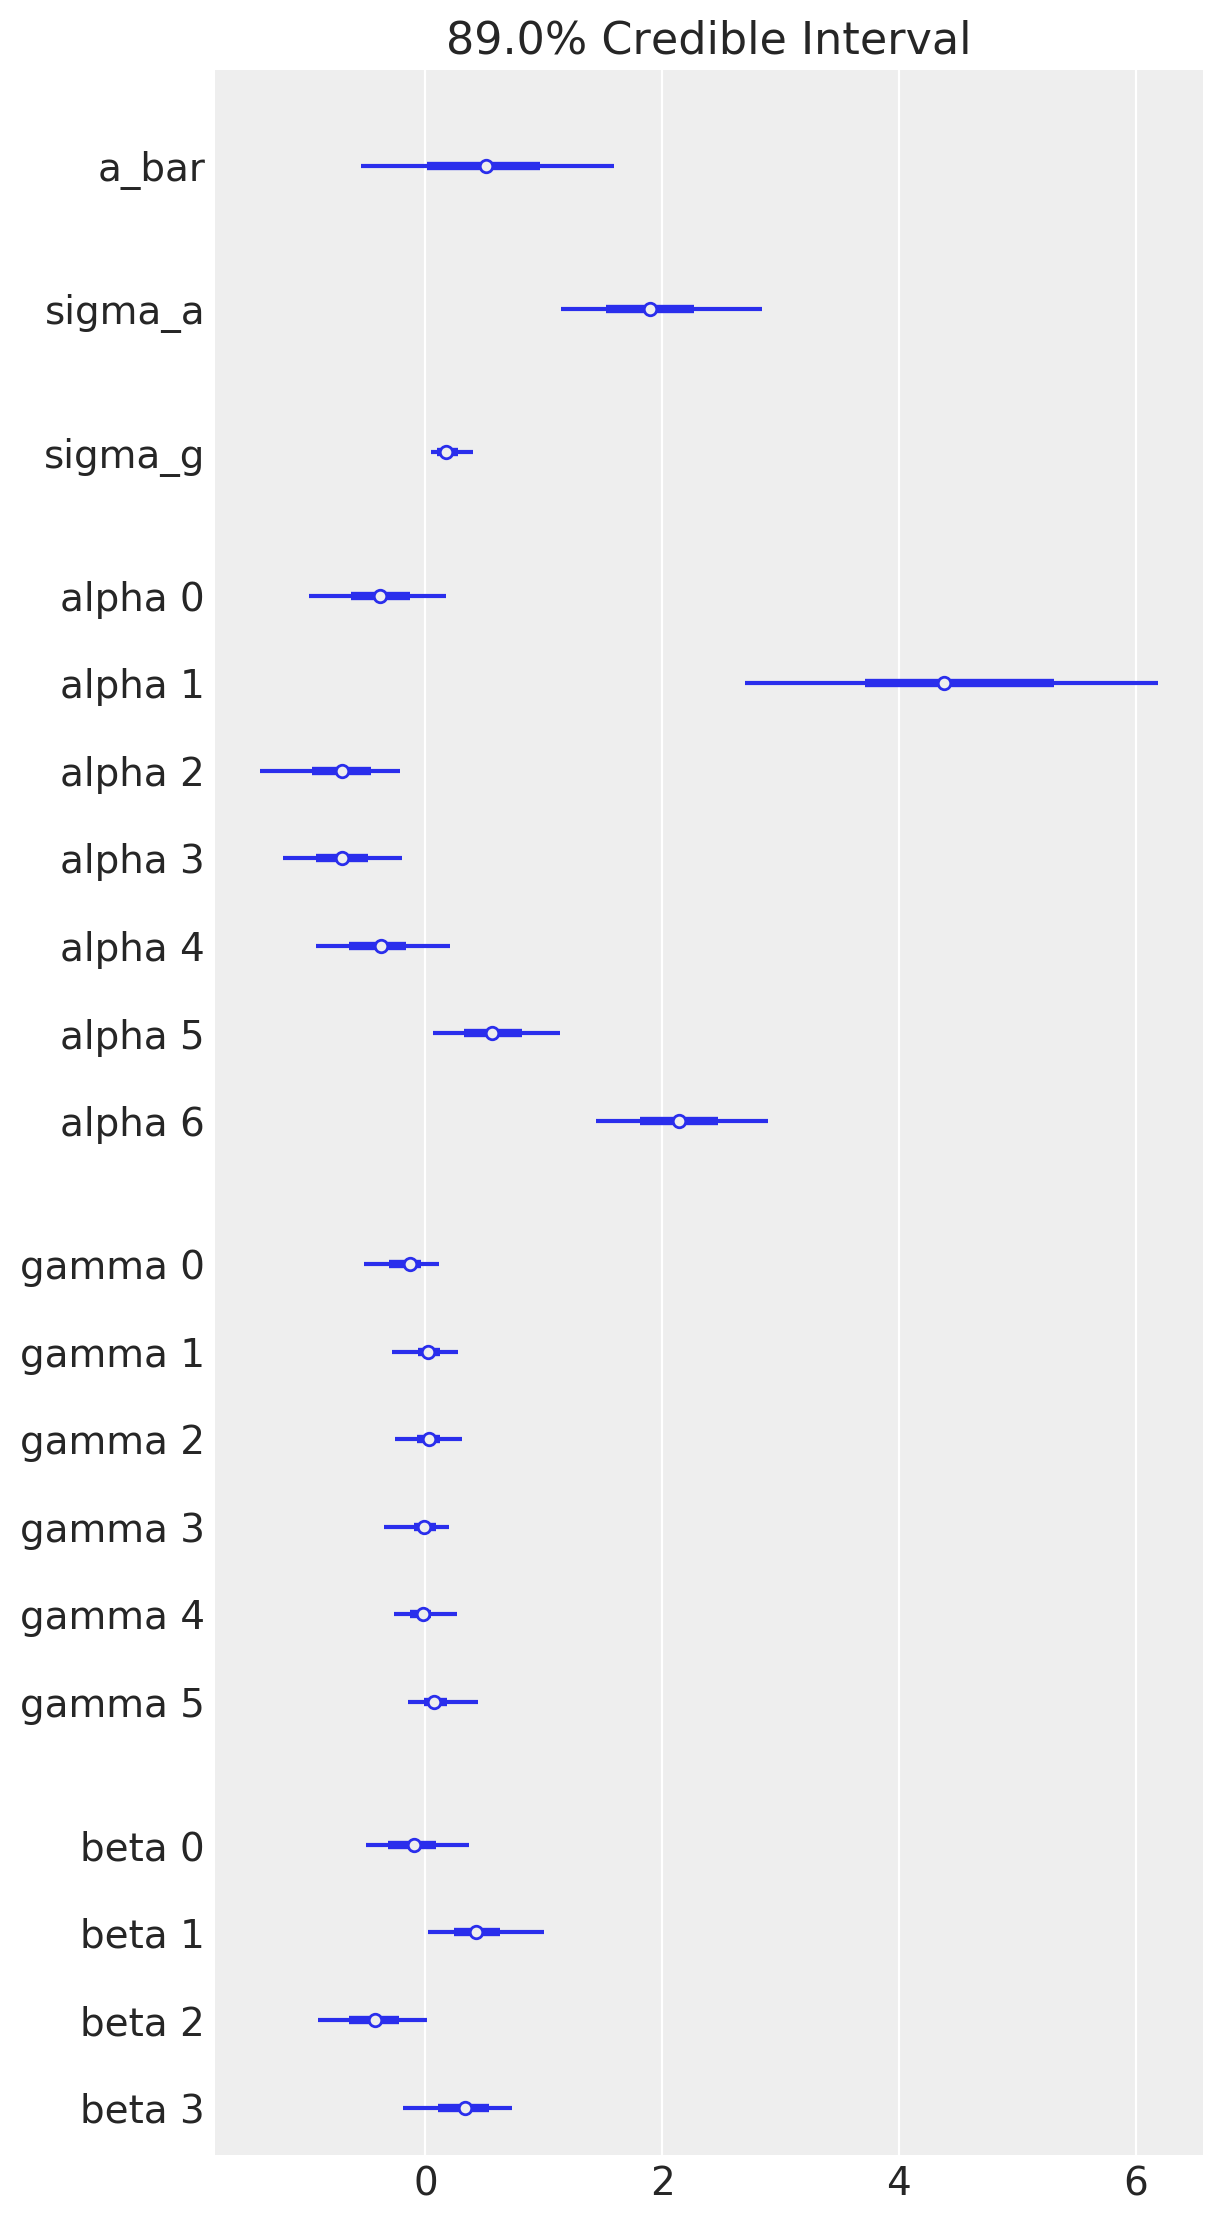

In [45]:
az.plot_forest(trace_13_4, combined=True, credible_interval=0.89); 

## Code 13.23

Build a model that ignores block so that we can then compare it with the above model

In [46]:
def model_13_5(actor, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # two terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_5 = model_13_5(dat["actor"], dat["treatment"])


NUM_CHAINS_FOR_13_5 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_5]),
    tf.ones([NUM_CHAINS_FOR_13_5]),    
    tf.zeros([NUM_CHAINS_FOR_13_5, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_5, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),        
    tfb.Identity(),
    tfb.Identity()
]

trace_13_5 = sample_posterior(jdc_13_5,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'alpha', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_5, 
                               init_state=init_state,
                               bijectors=bijectors)

## Code 13.24

In [47]:
def compute_and_store_log_likelihood_for_model_13_4(num_chains):

    def log_like_13_4(params):
        
        alpha  = params[0]
        gamma  = params[1]
        beta   = params[2]
        
        term1 = tf.squeeze(tf.gather(alpha, dat["actor"], axis=-1))
        term2 = tf.squeeze(tf.gather(gamma,dat["block_id"], axis=-1))
        term3 = tf.squeeze(tf.gather(beta, dat["treatment"] ,axis=-1))        
        
        p = tf.sigmoid(term1 + term2 + term3)                              
        
        return tfd.Binomial(total_count=1, probs=p).log_prob(dat["pulled_left"])

    log_likelihood_13_4 = []

    for i in range(num_chains):
        alpha = trace_13_4.posterior["alpha"].values[i]
        gamma = trace_13_4.posterior["gamma"].values[i]
        beta = trace_13_4.posterior["beta"].values[i]
        log_likelihood = np.array(list(map(log_like_13_4, zip(alpha, gamma, beta))))
        log_likelihood_13_4.append(log_likelihood)

    log_likelihood_13_4 = np.array(log_likelihood_13_4)

    # we need to insert this in the sampler_stats
    sample_stats_13_4 = trace_13_4.sample_stats

    coords = [sample_stats_13_4.coords['chain'], sample_stats_13_4.coords['draw'], np.arange(504)]

    sample_stats_13_4["log_likelihood"] = xr.DataArray(
        log_likelihood_13_4, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_4(num_chains=NUM_CHAINS_FOR_13_4)

In [48]:
def compute_and_store_log_likelihood_for_model_13_5(num_chains):

    def log_like_13_5(params):
        
        alpha = params[0]
        beta  = params[1]
        
        term1 = tf.squeeze(tf.gather(alpha, dat["actor"], axis=-1))
        term2 = tf.squeeze(tf.gather(beta, dat["treatment"] ,axis=-1))
        
        p = tf.sigmoid(term1 + term2)                              
        
        return tfd.Binomial(total_count=1, probs=p).log_prob(dat["pulled_left"])

    log_likelihood_13_5 = []

    for i in range(num_chains):
        alpha = trace_13_5.posterior["alpha"].values[i]
        beta = trace_13_5.posterior["beta"].values[i]
        log_likelihood = np.array(list(map(log_like_13_5, zip(alpha,beta))))
        log_likelihood_13_5.append(log_likelihood)

    log_likelihood_13_5 = np.array(log_likelihood_13_5)

    # we need to insert this in the sampler_stats
    sample_stats_13_5 = trace_13_5.sample_stats

    coords = [sample_stats_13_5.coords['chain'], sample_stats_13_5.coords['draw'], np.arange(504)]

    sample_stats_13_5["log_likelihood"] = xr.DataArray(
        log_likelihood_13_5, 
        coords=coords,  
        dims=['chain', 'draw', 'log_likelihood_dim_0'])
    
compute_and_store_log_likelihood_for_model_13_5(num_chains=NUM_CHAINS_FOR_13_5)

In [49]:
az.compare({"m13.4": trace_13_4, "m13.5": trace_13_5})

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m13.5,0,528.749,7.64878,0,0.836708,20.0715,0,False,deviance
m13.4,1,532.512,10.8237,3.76227,0.163292,19.8709,1.83977,False,deviance


Above 2 models seem to imply nearly identical predictions. Should we select m13.4 as it is simpler among the two ?. Author here suggests that to select a model, we should rather want to test conditional independencies of different causal models.

## Code 13.25

m13.4 with partial pooling on the treatments

In [50]:
def model_13_6(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_b = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))  
      # adaptive priors
      alpha = yield tfd.Sample(tfd.Normal(loc=a_bar, scale=sigma_a), sample_shape=7)
      gamma = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_g), sample_shape=6)  
      beta = yield tfd.Sample(tfd.Normal(loc=0., scale=sigma_b), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(alpha, actor, axis=-1))
      term2 = tf.squeeze(tf.gather(gamma,block_id,axis=-1))
      term3 = tf.squeeze(tf.gather(beta,treatment,axis=-1))
        
      p = tf.sigmoid(term1 + term2 + term3)              
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_6 = model_13_6(dat["actor"], dat["block_id"], dat["treatment"])

In [51]:
NUM_CHAINS_FOR_13_6 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.ones([NUM_CHAINS_FOR_13_6]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_6, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

trace_13_6 = sample_posterior(jdc_13_6,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'sigma_b', 'alpha', 'gamma', 'beta'],
                               num_chains=NUM_CHAINS_FOR_13_6, 
                               init_state=init_state,
                               bijectors=bijectors)

In [52]:
{"m13.4": np.mean(trace_13_4.posterior["beta"].values[1], 0),
 "m13.6": np.mean(trace_13_6.posterior["beta"].values[1], 0)}

{'m13.4': array([-0.15449232,  0.37498388, -0.46666422,  0.3004631 ], dtype=float32),
 'm13.6': array([-0.12050516,  0.36499783, -0.43940616,  0.2723066 ], dtype=float32)}

## Code 13.26 (TODO - add notes on divergence)

In [53]:
def model_13_7():
    def _generator():  
      v = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=3.), sample_shape=1))
      x = yield tfd.Sample(tfd.Normal(loc=0., scale=tf.exp(v)), sample_shape=1)       
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_7 = model_13_7()

In [54]:
NUM_CHAINS_FOR_13_7 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_7]),
    tf.zeros([NUM_CHAINS_FOR_13_7])   
]

bijectors = [    
    tfb.Identity(),
    tfb.Identity()
]

trace_13_7 = sample_posterior(jdc_13_7,
                               observed_data=(),
                               params=['v', 'x'],
                               num_chains=NUM_CHAINS_FOR_13_7, 
                               init_state=init_state,
                               bijectors=bijectors)

In [55]:
az.summary(trace_13_7)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v,-1.340,1.326,-2.665,0.071,0.930,0.785,2.0,2.0,2.0,2.0,2.85
x,-0.348,0.326,-0.723,-0.022,0.229,0.193,2.0,2.0,2.0,8.0,2.63


## Code 13.27

In [56]:
def model_13_7nc():
    def _generator():  
      v = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=3.), sample_shape=1))
      z = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=1))
      x = z * tf.exp(v)
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_7nc = model_13_7nc()

NUM_CHAINS_FOR_13_7nc = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_7nc]),
    tf.zeros([NUM_CHAINS_FOR_13_7nc])   
]

bijectors = [    
    tfb.Identity(),
    tfb.Identity()
]

trace_13_7nc = sample_posterior(jdc_13_7nc,
                               observed_data=(),
                               params=['v', 'z'],
                               num_chains=NUM_CHAINS_FOR_13_7nc, 
                               init_state=init_state,
                               bijectors=bijectors)

az.summary(trace_13_7nc)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v,0.018,2.931,-5.380,5.123,0.088,0.114,1099.0,330.0,1112.0,480.0,1.01
z,-0.091,1.028,-2.043,1.657,0.060,0.043,291.0,291.0,293.0,343.0,1.01


## Code 13.28 [TODO - parameterize the target accept prob]

## Code 13.29

In [57]:
def model_13_4nc(actor, block_id, treatment):
    def _generator():  
      # hyper-priors
      a_bar = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=1))
      sigma_a = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      sigma_g = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      # adaptive priors
      z = yield tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=7)
      x = yield tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=6)  
      b = yield tfd.Sample(tfd.Normal(loc=0., scale=0.5), sample_shape=4) 
        
      # three terms
      term1 = tf.squeeze(tf.gather(z, actor,     axis=-1))
      term2 = tf.squeeze(tf.gather(x, block_id,  axis=-1))
      term3 = tf.squeeze(tf.gather(b, treatment, axis=-1))        
        
      # reparamertization 
      r = a_bar[...,tf.newaxis] + sigma_a[...,tf.newaxis] * term1  \
                                + sigma_g[...,tf.newaxis] * term2  \
                                + term3
        
      p = tf.sigmoid(r)        
        
      PL = yield tfd.Independent(tfd.Binomial(total_count=1, probs=p), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_13_4nc = model_13_4nc(dat["actor"], dat["block_id"], dat["treatment"])

In [58]:
s = jdc_13_4nc.sample(2)

jdc_13_4nc.log_prob(s)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-329.78516, -330.42145],
       [-206.87543, -207.51172]], dtype=float32)>

In [59]:
NUM_CHAINS_FOR_13_4 = 2

init_state = [
    tf.zeros([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.ones([NUM_CHAINS_FOR_13_4]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 7]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 6]),
    tf.zeros([NUM_CHAINS_FOR_13_4, 4])
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity()
]

trace_13_4nc = sample_posterior(jdc_13_4nc,
                               observed_data=(dat["pulled_left"],),
                               params=['a_bar', 'sigma_a', 'sigma_g', 'z', 'x', 'b'],
                               num_chains=NUM_CHAINS_FOR_13_4, 
                               init_state=init_state,
                               bijectors=bijectors)

In [60]:
az.summary(trace_13_4nc)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,0.465,0.674,-0.663,1.841,0.154,0.110,19.0,19.0,19.0,29.0,1.14
sigma_a,1.941,0.628,0.890,3.137,0.184,0.134,12.0,12.0,13.0,30.0,1.16
sigma_g,0.154,0.148,0.000,0.460,0.049,0.036,9.0,9.0,8.0,30.0,1.18
z[0],-0.461,0.387,-1.188,0.252,0.082,0.059,22.0,22.0,25.0,26.0,1.10
z[1],2.322,0.765,0.952,3.671,0.169,0.121,20.0,20.0,19.0,79.0,1.13
z[2],-0.633,0.401,-1.358,0.092,0.080,0.057,25.0,25.0,26.0,28.0,1.10
z[3],-0.626,0.399,-1.216,0.217,0.083,0.059,23.0,23.0,24.0,25.0,1.08
z[4],-0.463,0.388,-1.051,0.427,0.080,0.057,24.0,24.0,26.0,27.0,1.10
z[5],0.071,0.384,-0.618,0.780,0.081,0.058,23.0,23.0,26.0,47.0,1.09
z[6],0.931,0.537,0.062,1.830,0.125,0.090,19.0,19.0,18.0,59.0,1.12


## Code 13.30 [TODO - do not how to compute ess]

## Code 13.31

In [61]:
chimp = 2
d_pred = dict(actor=np.repeat(chimp, 4) - 1,
              treatment=np.arange(4),
              block_id=np.repeat(1, 4) - 1)

# we want to calculate the p using the posterior

sample_alpha = trace_13_4.posterior["alpha"].values[0]
sample_gamma = trace_13_4.posterior["gamma"].values[0]
sample_beta  = trace_13_4.posterior["beta"].values[0]

term1 = tf.squeeze(tf.gather(sample_alpha, d_pred['actor'], axis=-1))
term2 = tf.squeeze(tf.gather(sample_gamma, d_pred['block_id'], axis=-1))
term3 = tf.squeeze(tf.gather(sample_beta, d_pred['treatment'], axis=-1))

p = tf.sigmoid(term1 + term2 + term3)

p_mu = np.mean(p, 0)
p_ci = np.percentile(p, q=(5.5, 94.5), axis=0)

p_mu, p_ci

(array([0.98087937, 0.9882921 , 0.9732783 , 0.9865944 ], dtype=float32),
 array([[0.93990088, 0.96342832, 0.91074619, 0.95623156],
        [0.99756312, 0.99849951, 0.99589499, 0.99819082]]))

## Code 13.32

In [62]:
{k: v.values[0].reshape(-1)[:5] for k, v in trace_13_4.posterior.items()}

{'a_bar': array([ 0.6058704 ,  0.4269058 , -0.01516441, -0.22978425, -0.02698955],
       dtype=float32),
 'sigma_a': array([1.6444856, 1.6563125, 1.792521 , 2.143243 , 1.801972 ],
       dtype=float32),
 'sigma_g': array([0.16946335, 0.19125578, 0.19259031, 0.16859478, 0.19172433],
       dtype=float32),
 'alpha': array([-0.31075245,  5.1881285 , -0.53778017, -0.4782483 , -0.14660269],
       dtype=float32),
 'gamma': array([ 0.10095698, -0.04648548,  0.02904126,  0.0908934 ,  0.14979869],
       dtype=float32),
 'beta': array([-1.7539226e-01, -2.8683171e-03, -9.3630403e-01, -2.8797977e-02,
        -3.2036705e-04], dtype=float32)}

## Code 13.33

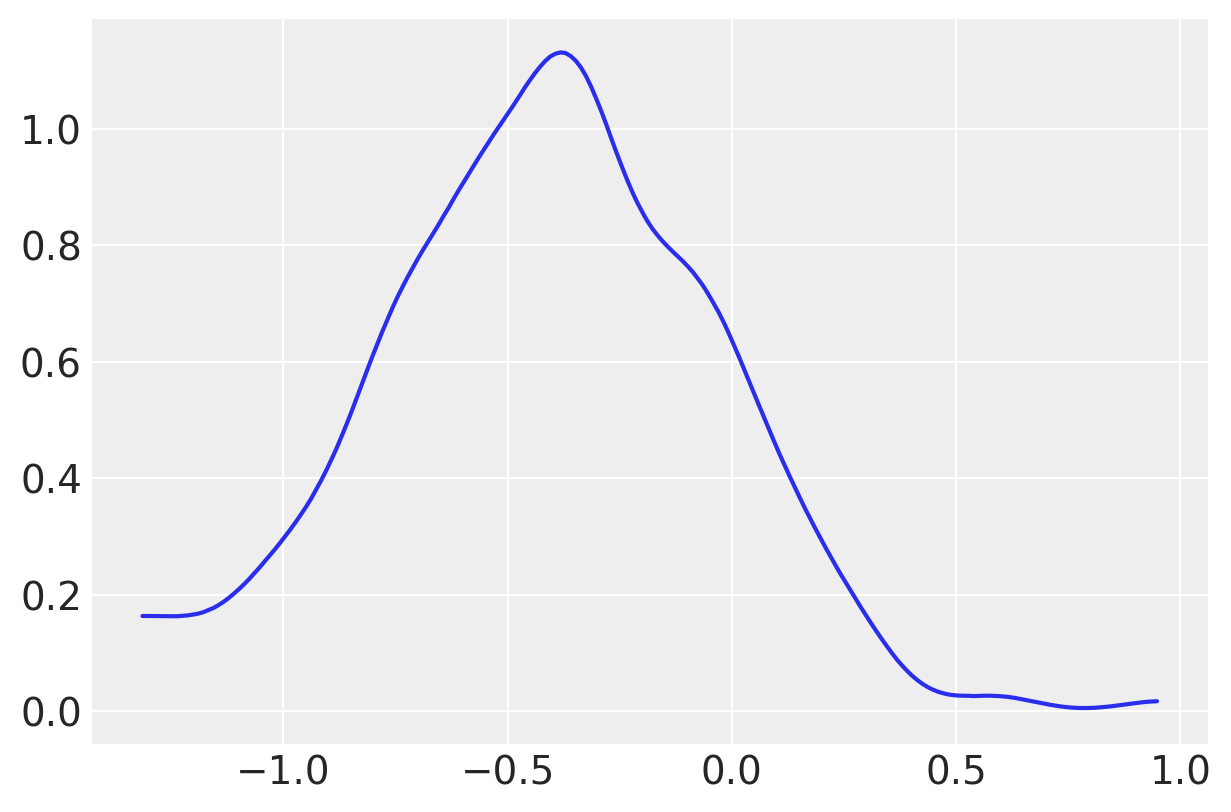

In [63]:
az.plot_kde(trace_13_4.posterior["alpha"].values[0][:, 4]);

## Code 13.34

In [64]:
post = trace_13_4.posterior

In [65]:
def p_link(treatment, actor=0, block_id=0):    
    a, g, b = post["alpha"].values[0], post["gamma"].values[0], post["beta"].values[0]
    logodds = a[:, actor] + g[:, block_id] + b[:, treatment]
    return tf.sigmoid(logodds)

## Code 13.35

In [66]:
p_raw = list(map(lambda i: p_link(i, actor=1, block_id=0), np.arange(4)))
p_mu = np.mean(p_raw, 0)
p_ci = np.percentile(p_raw, (5.5, 94.5), 0)

## Code 13.36

In [67]:
def p_link_abar(treatment):    
    logodds = post["a_bar"].values[0] + post["beta"].values[0][:, treatment]
    return tf.sigmoid(logodds)

## Code 13.37

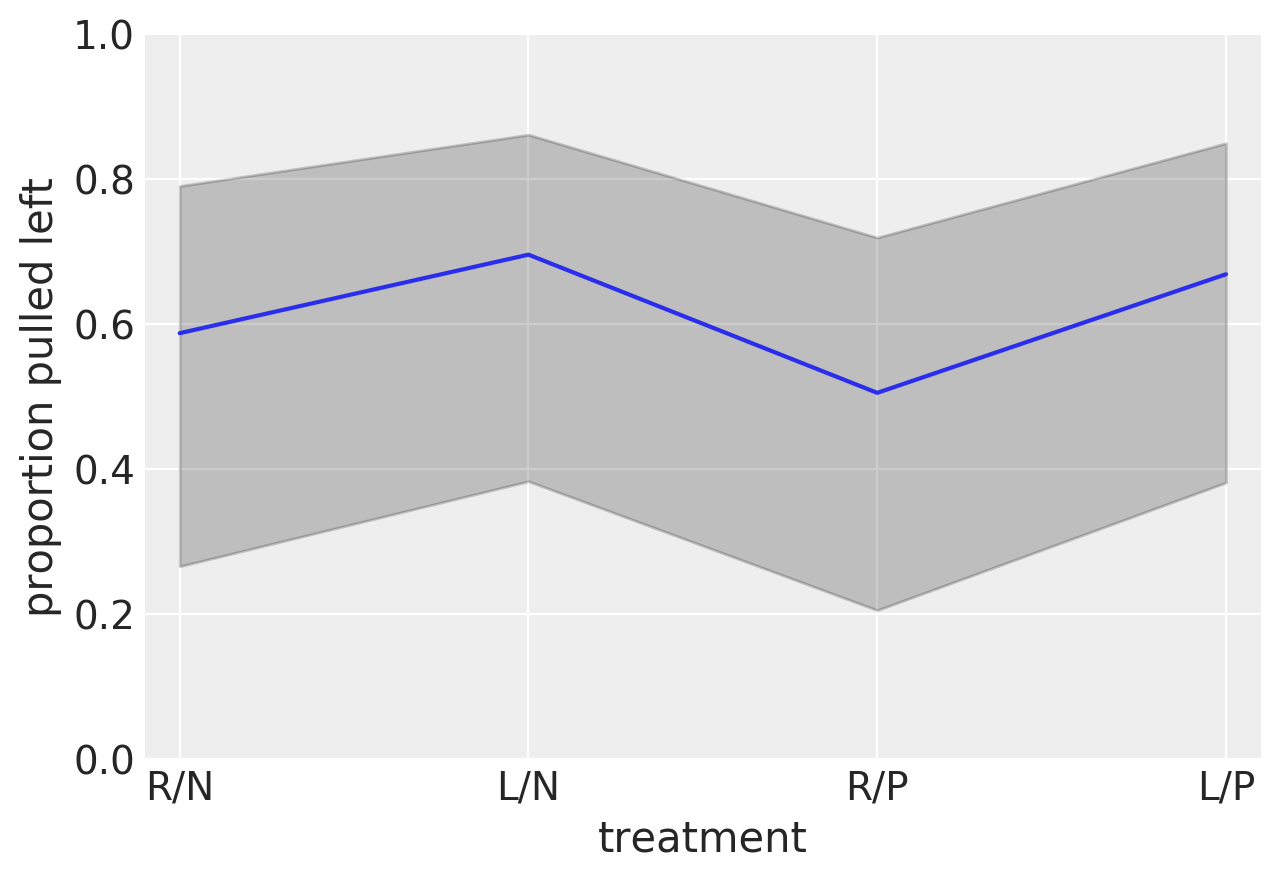

In [68]:
p_raw = list(map(p_link_abar, np.arange(4)))
p_mu = np.mean(p_raw, 1)
p_ci = np.percentile(p_raw, (5.5, 94.5), 1)

plt.subplot(xlabel="treatment", ylabel="proportion pulled left",
            ylim=(0, 1), xlim=(0.9, 4.1))
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
plt.plot(range(1, 5), p_mu)
plt.fill_between(range(1, 5), p_ci[0], p_ci[1], color="k", alpha=0.2);


## Code 13.38

In [69]:
a_sim = tfd.Normal(loc=post["a_bar"].values[0], scale=post["sigma_a"].values[0]).sample()

def p_link_asim(treatment):
    logodds = a_sim + post["beta"].values[0][:, treatment]
    return tf.sigmoid(logodds)

p_raw_asim = np.array(list(map(p_link_asim, np.arange(4))))

## Code 13.39

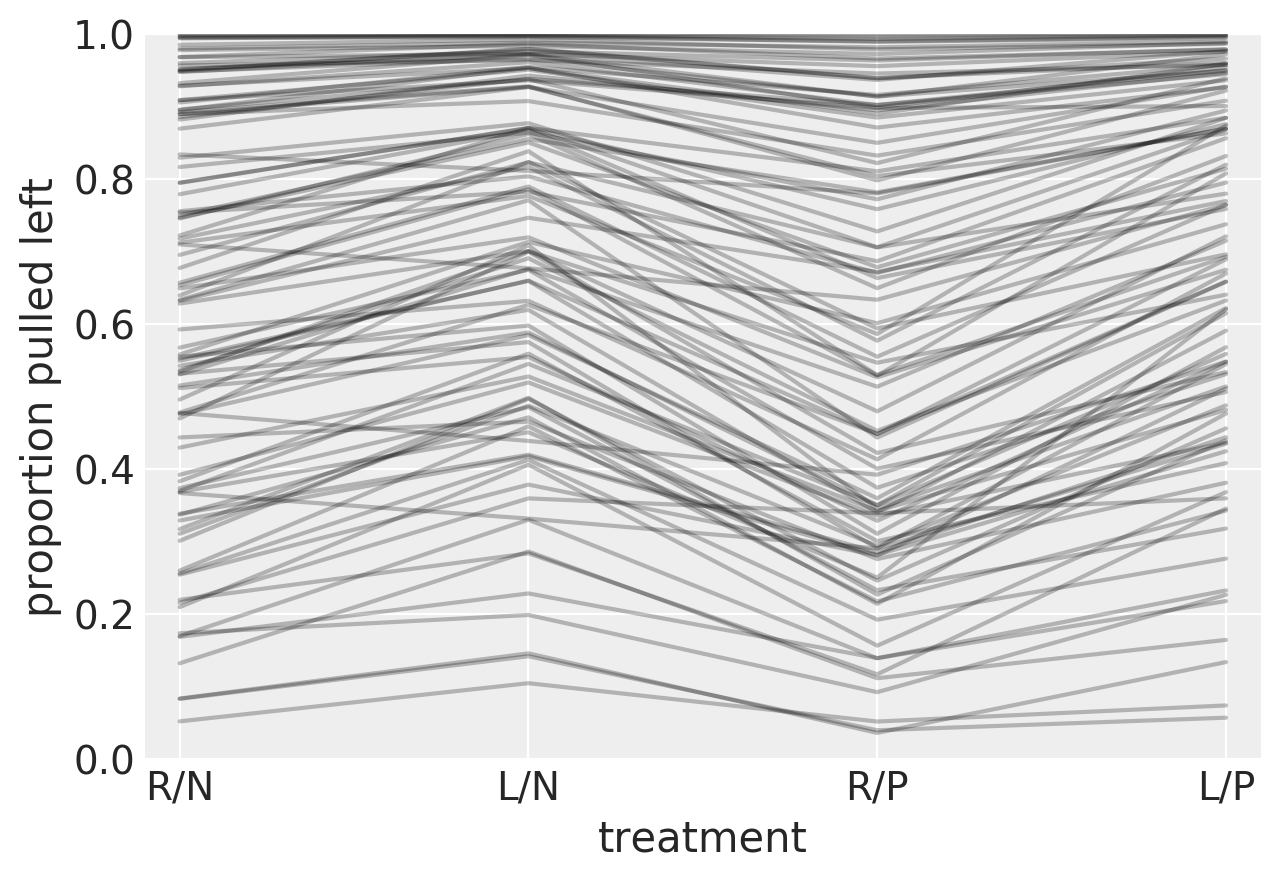

In [70]:
plt.subplot(xlabel="treatment", ylabel="proportion pulled left",
            ylim=(0, 1), xlim=(0.9, 4.1))
plt.gca().set(xticks=range(1, 5), xticklabels=["R/N", "L/N", "R/P", "L/P"])
for i in range(100):
    plt.plot(range(1, 5), p_raw_asim[:, i], color="k", alpha=0.25)